#### segment_id ベースの 4-1 割引クーポンキャンペーンの効果最大化

In [18]:
from pulp import LpProblem, LpVariable
from pulp import LpMaximize, LpStatus, lpSum, value
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time

In [19]:
files = glob('../*/*coupon/*.csv')
dfs = [pd.read_csv(file) for file in files]
# for df in dfs:
#     display(df.head(3), df.shape)

In [20]:
DM_SEND_MIN_RATE = 0.1
COST = [0, 1000, 2000]
DM_COST = {i+1:c for i, c in enumerate(COST)}

In [21]:
display(dfs[0].head(3))
display(dfs[1].head(3))

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0


,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74


In [22]:
c_df = dfs[0].copy()
p_df = dfs[1].copy()
# c_df, p_df マージ
c_p_df = pd.merge(c_df, p_df, on=['age_cat', 'freq_cat'])
c_p_df.head(3)

# セグメント別人数
p_df['seg_num'] = c_p_df.groupby('segment_id').count()['customer_id'].to_list()
p_df
# 計算用 prob1
p_df['prob1'] = p_df['prob_dm1']
p_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3,seg_num,prob1
0,age~19,freq0,1,0.07,0.12,0.29,200,0.07
1,age~19,freq1,2,0.21,0.30,0.58,150,0.21
2,age~19,freq2,3,0.28,0.39,0.74,50,0.28
3,age~19,freq3~,4,0.35,0.45,0.77,100,0.35
4,age20~34,freq0,5,0.11,0.17,0.37,600,0.11
5,age20~34,freq1,6,0.32,0.43,0.72,450,0.32
6,age20~34,freq2,7,0.42,0.55,0.93,150,0.42
7,age20~34,freq3~,8,0.52,0.63,0.94,300,0.52
8,age35~49,freq0,9,0.08,0.14,0.33,800,0.08
9,age35~49,freq1,10,0.25,0.35,0.67,600,0.25


In [23]:
# 縦置き
p_df = p_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})
p_melt_df = p_df.melt(id_vars=['segment_id', 'seg_num', 'prob1'], value_vars=[1, 2, 3], var_name='dm_type', value_name='prob')
# dmコスト
p_melt_df['dm_cost'] = p_melt_df['dm_type'].apply(lambda x: DM_COST[x])
p_melt_df.head(3)
# 変数定義
p_melt_df['variable'] = [LpVariable(name=f'x_seg_dm({r.segment_id:02},{r.dm_type})', cat='Binary') for r in p_melt_df.itertuples()]
p_melt_df.head(3)

,segment_id,seg_num,prob1,dm_type,prob,dm_cost,variable
0,1,200,0.07,1,0.07,0,"x_seg_dm(01,1)"
1,2,150,0.21,1,0.21,0,"x_seg_dm(02,1)"
2,3,50,0.28,1,0.28,0,"x_seg_dm(03,1)"


In [24]:
# 数理モデル
m = LpProblem('DiscountCouponProblem02_by_segment', sense=LpMaximize)

# DM効果最大化
m += lpSum(p_melt_df['seg_num'] * (p_melt_df['prob'] - p_melt_df['prob1']) * p_melt_df['variable'])

# 変数の割り当て
for k, r in p_melt_df.groupby('segment_id'):
    m += lpSum(r['variable']) == 1

# 最小送付率
for r in p_melt_df.itertuples():
    m += r.variable >= DM_SEND_MIN_RATE

# コスト制約
m += lpSum(p_melt_df['dm_cost'] * p_melt_df['seg_num'] * p_melt_df['prob'] * p_melt_df['variable']) <= 1000000

# m

In [25]:
# solve
start = time.time()
status = m.solve()
end = time.time()

# result
print(f'Status: {LpStatus[status]}')
print(f'Result: {value(m.objective):.02f}')
print(f'Time: {end - start:.02f} [sec]')

Status: Infeasible
Result: 326.10
Time: 0.07 [sec]


In [26]:
# 結果代入
p_melt_df['result'] = p_melt_df['variable'].apply(value)

In [27]:
# 横持変換
result_df = p_melt_df.pivot(index=['segment_id', 'seg_num'], columns='dm_type', values='result').reset_index(drop=True)
result_df
result_df = result_df.rename(columns={1: 'prob_dm1', 2: 'prob_dm2', 3: 'prob_dm3'})
seg_send_df = pd.concat([p_df[['segment_id', 'seg_num', 'age_cat', 'freq_cat']], result_df], axis=1)
seg_send_df

,segment_id,seg_num,age_cat,freq_cat,prob_dm1,prob_dm2,prob_dm3
0,1,200,age~19,freq0,0.1,0.800000,0.100000
1,2,150,age~19,freq1,0.8,0.100000,0.100000
2,3,50,age~19,freq2,0.8,0.100000,0.100000
3,4,100,age~19,freq3~,0.8,0.100000,0.100000
4,5,600,age20~34,freq0,0.8,0.100000,0.100000
5,6,450,age20~34,freq1,0.8,0.100000,0.100000
6,7,150,age20~34,freq2,0.8,0.100000,0.100000
7,8,300,age20~34,freq3~,0.8,0.100000,0.100000
8,9,800,age35~49,freq0,0.1,0.800000,0.100000
9,10,600,age35~49,freq1,0.8,0.100000,0.100000


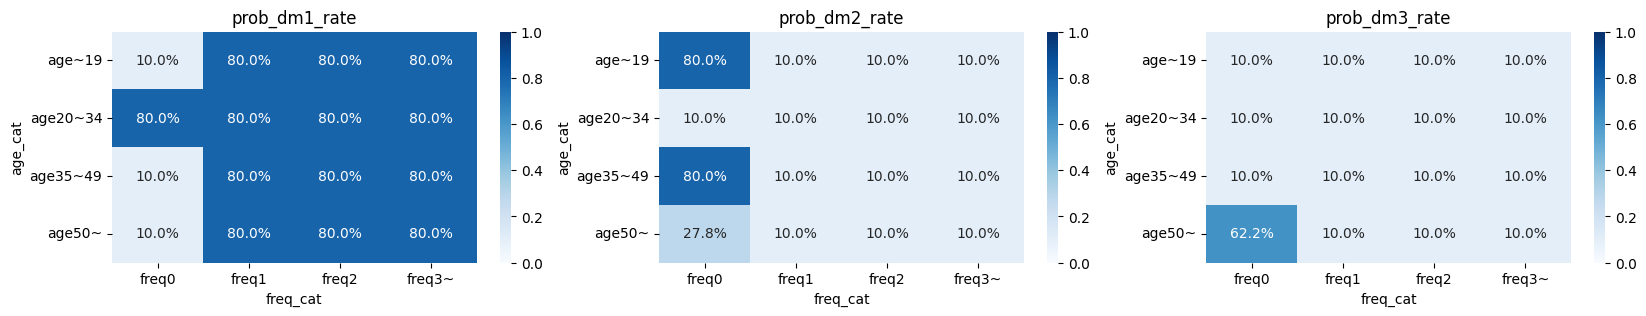

In [28]:
def plot(seg_send_df, aggfunc, vmax, fmt, text):
    fig, axs = plt.subplots(1, 3, figsize=(20, 3))
    for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
        pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc=aggfunc)
        pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
        sns.heatmap(pivot_df, vmin=0, vmax=vmax, annot=True, fmt=fmt, cmap='Blues', ax=axs[i])
        axs[i].set_title(f'{ptn}_{text}')


plot(seg_send_df, 'mean', 1, '.1%', f'rate')
# plot(seg_send_df, 'sum', 800, '.0f', f'num')